# Analyzing RSNA X-Ray Data with Convolutional Neural Networks

Carter Koehler

The primary purpose of this dataset is to determine a person's age based on their bone structure examined in an x-ray. The real value of this is determining how mature a person's skeleton is to determine if the patient has any perceptible growth defects, especially for children. For example, if a person's skeleton indicates that they should be 7 years old, but they are in fact 10, they are likely suffering from some sort of endocrine disorder. However, there are not many good quantitative measures for this, even fewer of which are fast and fully automated.

If a prediction algorithm were able to compute the age of a person's skeleton based on their x-ray data, that is enough to determine whether they are suffering from endocrine dysfunction.

This test does not need to be perfect, but it should do a reasonable job at predicting the presence or absence of endocrine dysfuntion. In particular, this form of testing should serve as a basic, first-pass screen, so that hospitals can save money on doing more costly, but more precise, tests on each individual. As a basic screening technique, when predicting whether or not someone's bones are inside or outside of the tolerable range of their age, we should prioritze decreasing the false negative rate to decreasing the false positive rate. It is always easier to run a patient through extra tests to find out that they aren't affected than it is to turn away a patient who is affected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.grid'] = True

import os
import sys
from pprint import pprint
from IPython.display import SVG

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.layers import Conv2D, MaxPooling2D, Reshape
from keras.models import Model
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD, Adagrad
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

Using TensorFlow backend.


## Data Preparation

In [2]:
file_dir = os.path.join(os.pardir, 'data')
compressed_dir = os.path.join(file_dir, 'boneage-compressed')

In [3]:
import pickle

boneage_data = np.array(pickle.load(open(os.path.join(compressed_dir, 'image_data.p'), 'rb')))

../data/boneage-compressed


In [12]:
boneage_metadata = pd.read_csv(os.path.join(file_dir, 'boneage.csv'))

#convert from months to years
boneage_target = (boneage_metadata['boneage']/12).astype(int)
np.unique(boneage_target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

So, we have 20 "classes." One could argue that they would be better served as a continuous variable, but then CNN's would be harder to apply to the problem.

## Evaluation Metric

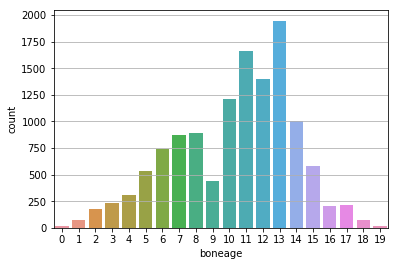

In [15]:
sns.countplot(data=(boneage_metadata/12).astype(int), x='boneage')

As addressed in the business case, we really care about minimizing the false negative rate of our predictive algorithm. To illustrate what precisely we care about, suppose a patient is given this screening process. Suppose then that the algorithm incorrectly gives their boneage to be something that it isn't, and the patient has to go through a couple other tests to find that they don't have some sort of endocrine dysfunction. Not much is lost here except a little bit of time. However, if the algorithm incorrectly predicts their bone age to be their actual age, this poses some serious problems.

This brings up the question of how to measure this hit/miss rate in the case of the data at hand, since we don't have both the bone age and actual age. However, it is almost certainly not very likely that the algorithm would incorrectly predict someone's bone age to be their actual age if there was a discrepancy. Thus, we are much more concerned with any given prediction being helpful than we are in picking up all of the examples of a given output class. Fortunately, precision scores measure for just this. 

As for addressing the issue of imbalanced classes, we note that we have the most instances of ages in late childhood and early adolescence. These ages are both young enough that endocrine disorders are more easily treatable and old enough that they might actually be detectable. So, conveniently, we have the most data on the classes we care most about. Because of this, we will use a micro-averaging scheme.

In [19]:
from sklearn.metrics import precision_score, make_scorer
avg_scheme = 'micro'
scorer = make_scorer(precision_score, average=avg_scheme)

## Cross-Validation Strategy